In [1]:
import optuna
import torch
import pandas as pd
from optuna.trial import TrialState
from optuna.samplers import TPESampler
from ANN_utility.Utils import seed_everything
from ANN_utility.ANN import Net
from ANN_utility.model_pipeline import model_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from ANN_utility.Data_preprocess import Data_preprocess

/Users/thechuongtrinh/anaconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **1. Defining objective function**

In [2]:
#Objective function returns f1 score value in cross validation test
def objective(trial):
    #Define searching space
    params_space ={"in_features" : 2048,
         "n_layers_mlp" : trial.suggest_int("n_layers_mlp", 2,6),
         "dense_neurons":  trial.suggest_int("dense_neurons", 128,2048),
               "epochs": trial.suggest_int("epochs", 50,100),
         "rate":trial.suggest_float("rate", 0.1, 0.8)}
    

    device = torch.device("mps")
    model_tune = Net(params_space).to(device)
    optimizer = torch.optim.Adam(model_tune.parameters(), lr= 0.0001, weight_decay = 0.01)
    criterion = torch.nn.BCELoss()
    save_dir = "./ANN_utility/ANN_model_tune.pth"

    pip = model_pipeline(model = model_tune, params = params_space, criterion = criterion, optimizer = optimizer, 
                    epochs = params_space["epochs"], seed = 42, device = device, save_dir  = save_dir)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=42)
    #Define X_train and y_train
    preprocess = Data_preprocess(path = "./Database/Secfp_ro5.csv", y_name = "pChEMBL",
                             threshold = 7, col_drop = "Canomicalsmiles",
                             device = device, batch_size = 32)
    preprocess.fit()
    X_train = preprocess.data_bin.drop(preprocess.data_bin.columns[0],axis = 1)
    y_train = preprocess.data_bin["pChEMBL"]
    #cross validation
    pip.cross_val_score(X=X_train, y=y_train, model = model_tune,cv=cv, batch_size = 32, device = device, verbose = True)

    return pip.mean_scores_f1

# **2. Tunning**

In [13]:
seed_everything(42)
#Sampler
sampler = TPESampler(seed = 42)

study = optuna.create_study(direction="maximize",sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-13 22:19:33,278] A new study created in memory with name: no-name-a8d87f18-e51a-4b71-a337-22d31311f9d1
  0%|                                                   | 0/100 [00:00<?, ?it/s]

Fold: 1..  validation f1_score: 0.829..  validation average precision: 0.842.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.886.. 
Fold: 4..  validation f1_score: 0.854..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.892..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.943.. 
Fold: 7..  validation f1_score: 0.857..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.895..  validation average precision: 0.950.. 
Fold: 9..  validation f1_score: 0.900..  validation average precision: 0.969.. 
Fold: 10..  validation f1_score: 0.921..  validation average precision: 0.956.. 
Fold: 11..  validation f1_score: 0.895..  validation average precision: 0.930.. 
Fold: 12..  validation f1_score: 0.892..  validation average precision: 0.957.. 
Fold: 13..  validation f1_score: 0.93

Best trial: 0. Best value: 0.88628:   1%|   | 1/100 [13:16<21:54:48, 796.85s/it]

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.871.. 
Overall AP score = 0.9361
Overall F1 score = 0.8863
[I 2023-10-13 22:32:50,161] Trial 0 finished with value: 0.886279951192114 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1954, 'epochs': 87, 'rate': 0.5190609389379257}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.782.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.985.. 
Fold: 3..  validation f1_score: 0.872..  validation average precision: 0.872.. 
Fold: 4..  validation f1_score: 0.846..  validation average precision: 0.956.. 
Fold: 5..  validation f1_score: 0.849..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.880..  validation average precision: 0.931.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.875..  validation average precision: 0.945.. 
Fol

Best trial: 0. Best value: 0.88628:   2%|   | 2/100 [18:03<13:31:45, 497.00s/it]

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.832.. 
Overall AP score = 0.9246
Overall F1 score = 0.8767
[I 2023-10-13 22:37:37,263] Trial 1 finished with value: 0.8766687230113372 and parameters: {'n_layers_mlp': 2, 'dense_neurons': 427, 'epochs': 52, 'rate': 0.7063233020424546}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.824..  validation average precision: 0.789.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.915.. 
Fold: 4..  validation f1_score: 0.900..  validation average precision: 0.975.. 
Fold: 5..  validation f1_score: 0.857..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.927.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.957.. 
Fold: 8..  validation f1_score: 0.895..  validation average precision: 0.954.. 
Fol

Best trial: 0. Best value: 0.88628:   3%|   | 3/100 [27:58<14:35:44, 541.70s/it]

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.873.. 
Overall AP score = 0.9382
Overall F1 score = 0.8859
[I 2023-10-13 22:47:32,158] Trial 2 finished with value: 0.8858642491969454 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 1488, 'epochs': 51, 'rate': 0.778936896513396}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.769..  validation average precision: 0.809.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.995.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.912.. 
Fold: 4..  validation f1_score: 0.829..  validation average precision: 0.954.. 
Fold: 5..  validation f1_score: 0.857..  validation average precision: 0.937.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.929.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.878..  validation average precision: 0.945.. 
Fol

Best trial: 0. Best value: 0.88628:   4%|   | 4/100 [39:52<16:15:16, 609.55s/it]

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.881.. 
Overall AP score = 0.9360
Overall F1 score = 0.8763
[I 2023-10-13 22:59:25,720] Trial 3 finished with value: 0.8763099943205734 and parameters: {'n_layers_mlp': 6, 'dense_neurons': 535, 'epochs': 59, 'rate': 0.22838315689740368}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.818..  validation average precision: 0.824.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.887.. 
Fold: 4..  validation f1_score: 0.883..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.873..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.838..  validation average precision: 0.933.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.864..  validation average precision: 0.957.. 
Fo

Best trial: 0. Best value: 0.88628:   5%|▏  | 5/100 [49:59<16:03:32, 608.55s/it]

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.882.. 
Overall AP score = 0.9363
Overall F1 score = 0.8838
[I 2023-10-13 23:09:32,510] Trial 4 finished with value: 0.8838136681501586 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1136, 'epochs': 72, 'rate': 0.30386039813862936}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.775..  validation average precision: 0.786.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.996.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.892.. 
Fold: 4..  validation f1_score: 0.846..  validation average precision: 0.962.. 
Fold: 5..  validation f1_score: 0.889..  validation average precision: 0.940.. 
Fold: 6..  validation f1_score: 0.872..  validation average precision: 0.937.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.872..  validation average precision: 0.946.. 
F

Best trial: 0. Best value: 0.88628:   6%| | 6/100 [1:01:06<16:24:30, 628.41s/it]

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.886.. 
Overall AP score = 0.9334
Overall F1 score = 0.8804
[I 2023-10-13 23:20:39,466] Trial 5 finished with value: 0.8803711394370399 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 395, 'epochs': 64, 'rate': 0.35645329030558426}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.785..  validation average precision: 0.825.. 
Fold: 2..  validation f1_score: 0.961..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.905.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.873..  validation average precision: 0.937.. 
Fold: 6..  validation f1_score: 0.827..  validation average precision: 0.923.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.902..  validation average precision: 0.960.. 
Fo

Best trial: 0. Best value: 0.88628:   7%| | 7/100 [1:10:56<15:54:39, 615.91s/it]

Fold: 30..  validation f1_score: 0.829..  validation average precision: 0.884.. 
Overall AP score = 0.9375
Overall F1 score = 0.8820
[I 2023-10-13 23:30:29,639] Trial 6 finished with value: 0.8820466404665753 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1636, 'epochs': 60, 'rate': 0.45996410688952816}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.769..  validation average precision: 0.836.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.857..  validation average precision: 0.902.. 
Fold: 4..  validation f1_score: 0.853..  validation average precision: 0.957.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.938.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.935.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.911..  validation average precision: 0.946.. 
F

Best trial: 0. Best value: 0.88628:   8%| | 8/100 [1:22:10<16:13:04, 634.61s/it]

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.885.. 
Overall AP score = 0.9355
Overall F1 score = 0.8819
[I 2023-10-13 23:41:44,305] Trial 7 finished with value: 0.8819449311640012 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 217, 'epochs': 80, 'rate': 0.2193668865811041}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.795..  validation average precision: 0.793.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.994.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.888.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.835..  validation average precision: 0.928.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.886..  validation average precision: 0.952.. 
Fol

Best trial: 0. Best value: 0.88628:   9%| | 9/100 [1:32:58<16:08:23, 638.50s/it]

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.843.. 
Overall AP score = 0.9318
Overall F1 score = 0.8811
[I 2023-10-13 23:52:31,357] Trial 8 finished with value: 0.8810952649645512 and parameters: {'n_layers_mlp': 2, 'dense_neurons': 1950, 'epochs': 99, 'rate': 0.6658781436815229}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.790..  validation average precision: 0.851.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.909.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.962.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.942.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.875..  validation average precision: 0.945.. 
Fo

Best trial: 0. Best value: 0.88628:  10%| | 10/100 [1:42:47<15:34:51, 623.24s/it

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.879.. 
Overall AP score = 0.9375
Overall F1 score = 0.8821
[I 2023-10-14 00:02:20,421] Trial 9 finished with value: 0.882080652407894 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 315, 'epochs': 84, 'rate': 0.408106745617721}. Best is trial 0 with value: 0.886279951192114.
Fold: 1..  validation f1_score: 0.829..  validation average precision: 0.833.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.896.. 
Fold: 4..  validation f1_score: 0.868..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.943.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.900..  validation average precision: 0.956.. 
Fold:

Best trial: 10. Best value: 0.886702:  11%| | 11/100 [1:55:15<16:21:28, 661.67s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.878.. 
Overall AP score = 0.9370
Overall F1 score = 0.8867
[I 2023-10-14 00:14:49,223] Trial 10 finished with value: 0.8867017548770005 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1037, 'epochs': 93, 'rate': 0.11257331293037381}. Best is trial 10 with value: 0.8867017548770005.
Fold: 1..  validation f1_score: 0.833..  validation average precision: 0.816.. 
Fold: 2..  validation f1_score: 0.947..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.885.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.964.. 
Fold: 5..  validation f1_score: 0.870..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.946.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.892..  validation average precision: 0.959..

Best trial: 10. Best value: 0.886702:  12%| | 12/100 [2:07:25<16:40:52, 682.42s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.874.. 
Overall AP score = 0.9367
Overall F1 score = 0.8823
[I 2023-10-14 00:26:59,098] Trial 11 finished with value: 0.8823170713442587 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 899, 'epochs': 94, 'rate': 0.12899334452911335}. Best is trial 10 with value: 0.8867017548770005.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.819.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.996.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.906.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.931.. 
Fold: 6..  validation f1_score: 0.865..  validation average precision: 0.948.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.949.. 

Best trial: 12. Best value: 0.888275:  13%|▏| 13/100 [2:19:21<16:43:59, 692.41s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.883.. 
Overall AP score = 0.9379
Overall F1 score = 0.8883
[I 2023-10-14 00:38:54,506] Trial 12 finished with value: 0.8882748046786553 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1070, 'epochs': 88, 'rate': 0.5147487907606363}. Best is trial 12 with value: 0.8882748046786553.
Fold: 1..  validation f1_score: 0.821..  validation average precision: 0.817.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.994.. 
Fold: 3..  validation f1_score: 0.838..  validation average precision: 0.885.. 
Fold: 4..  validation f1_score: 0.875..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.880..  validation average precision: 0.945.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.947.. 

Best trial: 12. Best value: 0.888275:  14%|▏| 14/100 [2:28:39<15:34:18, 651.84s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.862.. 
Overall AP score = 0.9334
Overall F1 score = 0.8806
[I 2023-10-14 00:48:12,592] Trial 13 finished with value: 0.8806083508308798 and parameters: {'n_layers_mlp': 2, 'dense_neurons': 962, 'epochs': 91, 'rate': 0.5336737601935195}. Best is trial 12 with value: 0.8882748046786553.
Fold: 1..  validation f1_score: 0.785..  validation average precision: 0.846.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.904.. 
Fold: 4..  validation f1_score: 0.886..  validation average precision: 0.975.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.932.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.933.. 
Fold: 7..  validation f1_score: 0.857..  validation average precision: 0.951.. 
Fold: 8..  validation f1_score: 0.914..  validation average precision: 0.960.. 


Best trial: 12. Best value: 0.888275:  15%|▏| 15/100 [2:40:58<16:00:32, 678.03s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.887.. 
Overall AP score = 0.9382
Overall F1 score = 0.8832
[I 2023-10-14 01:00:31,319] Trial 14 finished with value: 0.883178793651611 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1264, 'epochs': 77, 'rate': 0.15249591626932824}. Best is trial 12 with value: 0.8882748046786553.
Fold: 1..  validation f1_score: 0.843..  validation average precision: 0.830.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.911.. 
Fold: 4..  validation f1_score: 0.872..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.892..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.868..  validation average precision: 0.940.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.942.. 

Best trial: 12. Best value: 0.888275:  16%|▏| 16/100 [2:53:08<16:11:18, 693.79s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.883.. 
Overall AP score = 0.9371
Overall F1 score = 0.8862
[I 2023-10-14 01:12:41,705] Trial 15 finished with value: 0.8862126495979388 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 746, 'epochs': 100, 'rate': 0.29213948129773665}. Best is trial 12 with value: 0.8882748046786553.
Fold: 1..  validation f1_score: 0.779..  validation average precision: 0.823.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.917.. 
Fold: 4..  validation f1_score: 0.868..  validation average precision: 0.962.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.943.. 
Fold: 7..  validation f1_score: 0.868..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.902..  validation average precision: 0.946..

Best trial: 12. Best value: 0.888275:  17%|▏| 17/100 [3:10:39<18:28:10, 801.09s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.887.. 
Overall AP score = 0.9379
Overall F1 score = 0.8796
[I 2023-10-14 01:30:12,346] Trial 16 finished with value: 0.8795609333372146 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 1410, 'epochs': 91, 'rate': 0.5736650841537607}. Best is trial 12 with value: 0.8882748046786553.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.800.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.994.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.881.. 
Fold: 4..  validation f1_score: 0.861..  validation average precision: 0.965.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.932.. 
Fold: 6..  validation f1_score: 0.865..  validation average precision: 0.934.. 
Fold: 7..  validation f1_score: 0.868..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.949.. 

Best trial: 12. Best value: 0.888275:  18%|▏| 18/100 [3:17:38<15:38:15, 686.53s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.862.. 
Overall AP score = 0.9326
Overall F1 score = 0.8781
[I 2023-10-14 01:37:12,166] Trial 17 finished with value: 0.8780566245138509 and parameters: {'n_layers_mlp': 2, 'dense_neurons': 695, 'epochs': 72, 'rate': 0.4217737238984042}. Best is trial 12 with value: 0.8882748046786553.
Fold: 1..  validation f1_score: 0.833..  validation average precision: 0.840.. 
Fold: 2..  validation f1_score: 0.959..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.885.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.966.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.877..  validation average precision: 0.941.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.872..  validation average precision: 0.953.. 


Best trial: 12. Best value: 0.888275:  19%|▏| 19/100 [3:29:08<15:28:05, 687.47s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.877.. 
Overall AP score = 0.9376
Overall F1 score = 0.8820
[I 2023-10-14 01:48:41,839] Trial 18 finished with value: 0.882042704264962 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1116, 'epochs': 83, 'rate': 0.12431013897411454}. Best is trial 12 with value: 0.8882748046786553.
Fold: 1..  validation f1_score: 0.814..  validation average precision: 0.864.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.892..  validation average precision: 0.899.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.945.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.914..  validation average precision: 0.951.. 

Best trial: 19. Best value: 0.888337:  20%|▏| 20/100 [3:44:59<17:02:05, 766.57s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.861.. 
Overall AP score = 0.9386
Overall F1 score = 0.8883
[I 2023-10-14 02:04:32,754] Trial 19 finished with value: 0.8883369004997506 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1600, 'epochs': 95, 'rate': 0.3525194148475543}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.805..  validation average precision: 0.818.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.912.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.873..  validation average precision: 0.931.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.930.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.914..  validation average precision: 0.961.. 

Best trial: 19. Best value: 0.888337:  21%|▏| 21/100 [4:06:27<20:15:13, 922.96s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.885.. 
Overall AP score = 0.9376
Overall F1 score = 0.8831
[I 2023-10-14 02:26:00,339] Trial 20 finished with value: 0.8831063607297732 and parameters: {'n_layers_mlp': 6, 'dense_neurons': 1769, 'epochs': 97, 'rate': 0.36768009413617886}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.824..  validation average precision: 0.860.. 
Fold: 2..  validation f1_score: 0.959..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.895.. 
Fold: 4..  validation f1_score: 0.886..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.931.. 
Fold: 6..  validation f1_score: 0.877..  validation average precision: 0.949.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.951.. 
Fold: 8..  validation f1_score: 0.881..  validation average precision: 0.950..

Best trial: 19. Best value: 0.888337:  22%|▏| 22/100 [4:21:05<19:42:25, 909.56s/

Fold: 30..  validation f1_score: 0.829..  validation average precision: 0.892.. 
Overall AP score = 0.9379
Overall F1 score = 0.8848
[I 2023-10-14 02:40:38,639] Trial 21 finished with value: 0.8848030986728562 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1314, 'epochs': 90, 'rate': 0.10172008718730416}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.786..  validation average precision: 0.876.. 
Fold: 2..  validation f1_score: 0.959..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.899.. 
Fold: 4..  validation f1_score: 0.886..  validation average precision: 0.967.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.932.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.936.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.951.. 
Fold: 8..  validation f1_score: 0.881..  validation average precision: 0.954..

Best trial: 19. Best value: 0.888337:  23%|▏| 23/100 [4:35:39<19:13:30, 898.84s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.872.. 
Overall AP score = 0.9365
Overall F1 score = 0.8829
[I 2023-10-14 02:55:12,485] Trial 22 finished with value: 0.8829054542182662 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 946, 'epochs': 95, 'rate': 0.2206720436271094}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.816.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.993.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.898.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.963.. 
Fold: 5..  validation f1_score: 0.892..  validation average precision: 0.939.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.946.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.914..  validation average precision: 0.962.. 


Best trial: 19. Best value: 0.888337:  24%|▏| 24/100 [4:47:54<17:56:26, 849.82s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.864.. 
Overall AP score = 0.9363
Overall F1 score = 0.8881
[I 2023-10-14 03:07:27,958] Trial 23 finished with value: 0.8881489556414427 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1608, 'epochs': 86, 'rate': 0.46631715390680484}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.841.. 
Fold: 2..  validation f1_score: 0.961..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.898.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.967.. 
Fold: 5..  validation f1_score: 0.853..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.931.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.951.. 
Fold: 8..  validation f1_score: 0.886..  validation average precision: 0.957..

Best trial: 19. Best value: 0.888337:  25%|▎| 25/100 [5:04:35<18:38:52, 895.11s/

Fold: 30..  validation f1_score: 0.829..  validation average precision: 0.883.. 
Overall AP score = 0.9374
Overall F1 score = 0.8843
[I 2023-10-14 03:24:08,706] Trial 24 finished with value: 0.884272918128324 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 1662, 'epochs': 86, 'rate': 0.4612200470791643}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.790..  validation average precision: 0.833.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.849..  validation average precision: 0.894.. 
Fold: 4..  validation f1_score: 0.841..  validation average precision: 0.963.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.929.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.939.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.907..  validation average precision: 0.955.. 


Best trial: 19. Best value: 0.888337:  26%|▎| 26/100 [5:17:48<17:46:08, 864.43s/

Fold: 30..  validation f1_score: 0.829..  validation average precision: 0.884.. 
Overall AP score = 0.9379
Overall F1 score = 0.8797
[I 2023-10-14 03:37:21,586] Trial 25 finished with value: 0.8797054941235607 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1524, 'epochs': 80, 'rate': 0.5090741796762881}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.847..  validation average precision: 0.847.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.884.. 
Fold: 4..  validation f1_score: 0.854..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.944.. 
Fold: 7..  validation f1_score: 0.846..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.892..  validation average precision: 0.949.. 

Best trial: 19. Best value: 0.888337:  27%|▎| 27/100 [5:30:43<16:59:08, 837.66s/

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.860.. 
Overall AP score = 0.9361
Overall F1 score = 0.8865
[I 2023-10-14 03:50:16,767] Trial 26 finished with value: 0.8865390674281216 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1797, 'epochs': 87, 'rate': 0.5795027209257861}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.821..  validation average precision: 0.814.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.994.. 
Fold: 3..  validation f1_score: 0.838..  validation average precision: 0.873.. 
Fold: 4..  validation f1_score: 0.843..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.932.. 
Fold: 6..  validation f1_score: 0.831..  validation average precision: 0.943.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.921..  validation average precision: 0.944.. 

Best trial: 19. Best value: 0.888337:  28%|▎| 28/100 [5:38:36<14:33:44, 728.12s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.854.. 
Overall AP score = 0.9326
Overall F1 score = 0.8811
[I 2023-10-14 03:58:09,328] Trial 27 finished with value: 0.8811330791320409 and parameters: {'n_layers_mlp': 2, 'dense_neurons': 1252, 'epochs': 74, 'rate': 0.4727407108964142}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.844.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.899.. 
Fold: 4..  validation f1_score: 0.872..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.951.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.886..  validation average precision: 0.957.. 

Best trial: 19. Best value: 0.888337:  29%|▎| 29/100 [5:50:43<14:21:15, 727.82s/

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.864.. 
Overall AP score = 0.9383
Overall F1 score = 0.8831
[I 2023-10-14 04:10:16,438] Trial 28 finished with value: 0.88309078189911 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1805, 'epochs': 81, 'rate': 0.3991242238501444}. Best is trial 19 with value: 0.8883369004997506.
Fold: 1..  validation f1_score: 0.818..  validation average precision: 0.821.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.891.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.967.. 
Fold: 5..  validation f1_score: 0.889..  validation average precision: 0.938.. 
Fold: 6..  validation f1_score: 0.880..  validation average precision: 0.948.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.911..  validation average precision: 0.964.. 
F

Best trial: 29. Best value: 0.888873:  30%|▎| 30/100 [6:07:04<15:37:43, 803.76s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.869.. 
Overall AP score = 0.9362
Overall F1 score = 0.8889
[I 2023-10-14 04:26:37,379] Trial 29 finished with value: 0.8888731573366351 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 2002, 'epochs': 88, 'rate': 0.49523524790463025}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.814..  validation average precision: 0.833.. 
Fold: 2..  validation f1_score: 0.961..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.900.. 
Fold: 4..  validation f1_score: 0.872..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.927.. 
Fold: 6..  validation f1_score: 0.868..  validation average precision: 0.951.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.936..

Best trial: 29. Best value: 0.888873:  31%|▎| 31/100 [6:25:17<17:04:11, 890.60s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.879.. 
Overall AP score = 0.9374
Overall F1 score = 0.8839
[I 2023-10-14 04:44:50,617] Trial 30 finished with value: 0.8839122083318223 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 2034, 'epochs': 89, 'rate': 0.5542237963274315}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.828..  validation average precision: 0.850.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.881.. 
Fold: 4..  validation f1_score: 0.875..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.936.. 
Fold: 7..  validation f1_score: 0.815..  validation average precision: 0.959.. 
Fold: 8..  validation f1_score: 0.914..  validation average precision: 0.954.. 

Best trial: 29. Best value: 0.888873:  32%|▎| 32/100 [6:41:20<17:14:05, 912.43s/

Fold: 30..  validation f1_score: 0.829..  validation average precision: 0.867.. 
Overall AP score = 0.9344
Overall F1 score = 0.8808
[I 2023-10-14 05:00:53,985] Trial 31 finished with value: 0.8808482978608986 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1935, 'epochs': 87, 'rate': 0.4940849493278733}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.851.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.913.. 
Fold: 4..  validation f1_score: 0.889..  validation average precision: 0.973.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.883..  validation average precision: 0.947.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.878..  validation average precision: 0.964.. 

Best trial: 29. Best value: 0.888873:  33%|▎| 33/100 [6:57:14<17:12:42, 924.82s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.868.. 
Overall AP score = 0.9400
Overall F1 score = 0.8841
[I 2023-10-14 05:16:47,706] Trial 32 finished with value: 0.8840819090861943 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1625, 'epochs': 96, 'rate': 0.43391911790967286}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.847.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.885.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.966.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.873..  validation average precision: 0.942.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.907..  validation average precision: 0.952..

Best trial: 29. Best value: 0.888873:  34%|▎| 34/100 [7:08:42<15:39:07, 853.75s/

Fold: 30..  validation f1_score: 0.819..  validation average precision: 0.873.. 
Overall AP score = 0.9377
Overall F1 score = 0.8840
[I 2023-10-14 05:28:15,642] Trial 33 finished with value: 0.8839701678270575 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1447, 'epochs': 83, 'rate': 0.5150108542777945}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.780..  validation average precision: 0.841.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.899.. 
Fold: 4..  validation f1_score: 0.875..  validation average precision: 0.966.. 
Fold: 5..  validation f1_score: 0.873..  validation average precision: 0.931.. 
Fold: 6..  validation f1_score: 0.868..  validation average precision: 0.942.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.907..  validation average precision: 0.947.. 

Best trial: 29. Best value: 0.888873:  35%|▎| 35/100 [7:25:25<16:13:19, 898.45s/

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.878.. 
Overall AP score = 0.9366
Overall F1 score = 0.8824
[I 2023-10-14 05:44:58,390] Trial 34 finished with value: 0.8824377267608503 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1864, 'epochs': 92, 'rate': 0.627761803084825}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.805..  validation average precision: 0.815.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.993.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.885.. 
Fold: 4..  validation f1_score: 0.889..  validation average precision: 0.966.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.880..  validation average precision: 0.928.. 
Fold: 7..  validation f1_score: 0.853..  validation average precision: 0.951.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.945.. 


Best trial: 29. Best value: 0.888873:  36%|▎| 36/100 [7:33:58<13:55:11, 783.00s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.853.. 
Overall AP score = 0.9328
Overall F1 score = 0.8830
[I 2023-10-14 05:53:31,991] Trial 35 finished with value: 0.8829547790542003 and parameters: {'n_layers_mlp': 2, 'dense_neurons': 1352, 'epochs': 78, 'rate': 0.4873769140924199}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.829..  validation average precision: 0.802.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.872..  validation average precision: 0.900.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.966.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.940.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.900..  validation average precision: 0.952.. 

Best trial: 29. Best value: 0.888873:  37%|▎| 37/100 [7:43:43<12:39:49, 723.64s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.877.. 
Overall AP score = 0.9356
Overall F1 score = 0.8798
[I 2023-10-14 06:03:17,116] Trial 36 finished with value: 0.8798084428583355 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1528, 'epochs': 68, 'rate': 0.6046764792310593}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.780..  validation average precision: 0.828.. 
Fold: 2..  validation f1_score: 0.987..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.846..  validation average precision: 0.907.. 
Fold: 4..  validation f1_score: 0.857..  validation average precision: 0.967.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.937.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.886..  validation average precision: 0.956.. 

Best trial: 29. Best value: 0.888873:  38%|▍| 38/100 [8:00:35<13:57:06, 810.11s/

Fold: 30..  validation f1_score: 0.829..  validation average precision: 0.883.. 
Overall AP score = 0.9380
Overall F1 score = 0.8789
[I 2023-10-14 06:20:08,988] Trial 37 finished with value: 0.8789487693576562 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 738, 'epochs': 89, 'rate': 0.5464209936039549}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.769..  validation average precision: 0.857.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.899.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.922.. 
Fold: 6..  validation f1_score: 0.872..  validation average precision: 0.943.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.895..  validation average precision: 0.953.. 


Best trial: 29. Best value: 0.888873:  39%|▍| 39/100 [8:19:25<15:20:59, 905.90s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.888.. 
Overall AP score = 0.9385
Overall F1 score = 0.8821
[I 2023-10-14 06:38:58,411] Trial 38 finished with value: 0.882111036274662 and parameters: {'n_layers_mlp': 6, 'dense_neurons': 1704, 'epochs': 85, 'rate': 0.44439499046639364}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.805..  validation average precision: 0.855.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.903.. 
Fold: 4..  validation f1_score: 0.868..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.838..  validation average precision: 0.939.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.914..  validation average precision: 0.957.. 

Best trial: 29. Best value: 0.888873:  40%|▍| 40/100 [8:37:23<15:57:32, 957.54s/

Fold: 30..  validation f1_score: 0.800..  validation average precision: 0.862.. 
Overall AP score = 0.9371
Overall F1 score = 0.8795
[I 2023-10-14 06:56:56,444] Trial 39 finished with value: 0.8794662166050884 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 1175, 'epochs': 97, 'rate': 0.36940789770462074}. Best is trial 29 with value: 0.8888731573366351.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.838.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.996.. 
Fold: 3..  validation f1_score: 0.895..  validation average precision: 0.901.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.865..  validation average precision: 0.929.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.947.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.948..

Best trial: 40. Best value: 0.88921:  41%|▍| 41/100 [8:52:02<15:18:30, 934.08s/i

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.846.. 
Overall AP score = 0.9382
Overall F1 score = 0.8892
[I 2023-10-14 07:11:35,781] Trial 40 finished with value: 0.8892103834409472 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1530, 'epochs': 88, 'rate': 0.7564655049173445}. Best is trial 40 with value: 0.8892103834409472.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.838.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.995.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.905.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.924.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.954.. 

Best trial: 40. Best value: 0.88921:  42%|▍| 42/100 [9:07:29<15:00:53, 931.96s/i

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.880.. 
Overall AP score = 0.9390
Overall F1 score = 0.8871
[I 2023-10-14 07:27:02,804] Trial 41 finished with value: 0.8871100714197157 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1570, 'epochs': 94, 'rate': 0.7995894458613797}. Best is trial 40 with value: 0.8892103834409472.
Fold: 1..  validation f1_score: 0.805..  validation average precision: 0.816.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.898.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.880..  validation average precision: 0.941.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.945.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.895..  validation average precision: 0.954.. 

Best trial: 40. Best value: 0.88921:  43%|▍| 43/100 [9:23:58<15:01:37, 949.07s/i

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.845.. 
Overall AP score = 0.9365
Overall F1 score = 0.8830
[I 2023-10-14 07:43:31,807] Trial 42 finished with value: 0.8829860552219027 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 2041, 'epochs': 88, 'rate': 0.6389194196265613}. Best is trial 40 with value: 0.8892103834409472.
Fold: 1..  validation f1_score: 0.814..  validation average precision: 0.810.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.893.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.938.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.956.. 

Best trial: 40. Best value: 0.88921:  44%|▍| 44/100 [9:35:08<13:27:47, 865.49s/i

Fold: 30..  validation f1_score: 0.829..  validation average precision: 0.879.. 
Overall AP score = 0.9364
Overall F1 score = 0.8779
[I 2023-10-14 07:54:42,277] Trial 43 finished with value: 0.8778642829223966 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1400, 'epochs': 83, 'rate': 0.7305513421691193}. Best is trial 40 with value: 0.8892103834409472.
Fold: 1..  validation f1_score: 0.785..  validation average precision: 0.824.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.907.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.937.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.940.. 
Fold: 7..  validation f1_score: 0.892..  validation average precision: 0.959.. 
Fold: 8..  validation f1_score: 0.937..  validation average precision: 0.961.. 

Best trial: 44. Best value: 0.889312:  45%|▍| 45/100 [9:52:53<14:08:10, 925.27s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.849.. 
Overall AP score = 0.9367
Overall F1 score = 0.8893
[I 2023-10-14 08:12:27,038] Trial 44 finished with value: 0.889312254087039 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1880, 'epochs': 98, 'rate': 0.7475885274186596}. Best is trial 44 with value: 0.889312254087039.
Fold: 1..  validation f1_score: 0.810..  validation average precision: 0.828.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.898.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.941.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.957.. 
F

Best trial: 44. Best value: 0.889312:  46%|▍| 46/100 [10:02:48<12:23:32, 826.15s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.883.. 
Overall AP score = 0.9389
Overall F1 score = 0.8855
[I 2023-10-14 08:22:21,897] Trial 45 finished with value: 0.8854998109962816 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1970, 'epochs': 54, 'rate': 0.7121011309798538}. Best is trial 44 with value: 0.889312254087039.
Fold: 1..  validation f1_score: 0.810..  validation average precision: 0.851.. 
Fold: 2..  validation f1_score: 0.946..  validation average precision: 0.996.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.902.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.931.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.927.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.923..  validation average precision: 0.954.. 


Best trial: 44. Best value: 0.889312:  47%|▍| 47/100 [10:20:45<13:16:06, 901.26s

Fold: 30..  validation f1_score: 0.861..  validation average precision: 0.846.. 
Overall AP score = 0.9387
Overall F1 score = 0.8891
[I 2023-10-14 08:40:18,421] Trial 46 finished with value: 0.889145943211665 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1898, 'epochs': 99, 'rate': 0.7711693868172427}. Best is trial 44 with value: 0.889312254087039.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.823.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.861..  validation average precision: 0.895.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.975.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.932.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.935.. 
Fold: 7..  validation f1_score: 0.868..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.886..  validation average precision: 0.962.. 
F

Best trial: 44. Best value: 0.889312:  48%|▍| 48/100 [10:39:03<13:52:21, 960.42s

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.847.. 
Overall AP score = 0.9368
Overall F1 score = 0.8818
[I 2023-10-14 08:58:36,863] Trial 47 finished with value: 0.8818316809302822 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1920, 'epochs': 99, 'rate': 0.7352715594024438}. Best is trial 44 with value: 0.889312254087039.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.849.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.888.. 
Fold: 4..  validation f1_score: 0.895..  validation average precision: 0.976.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.850..  validation average precision: 0.942.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.959.. 


Best trial: 44. Best value: 0.889312:  49%|▍| 49/100 [10:57:36<14:15:07, 1006.03

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.873.. 
Overall AP score = 0.9389
Overall F1 score = 0.8854
[I 2023-10-14 09:17:09,319] Trial 48 finished with value: 0.8854424732613491 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1727, 'epochs': 93, 'rate': 0.7524587490546019}. Best is trial 44 with value: 0.889312254087039.
Fold: 1..  validation f1_score: 0.824..  validation average precision: 0.848.. 
Fold: 2..  validation f1_score: 0.959..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.861..  validation average precision: 0.922.. 
Fold: 4..  validation f1_score: 0.868..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.854..  validation average precision: 0.947.. 
Fold: 7..  validation f1_score: 0.853..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.951.. 


Best trial: 44. Best value: 0.889312:  50%|▌| 50/100 [11:20:08<15:25:05, 1110.11

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.874.. 
Overall AP score = 0.9407
Overall F1 score = 0.8817
[I 2023-10-14 09:39:42,274] Trial 49 finished with value: 0.8816773967923653 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 1864, 'epochs': 100, 'rate': 0.6854944669134407}. Best is trial 44 with value: 0.889312254087039.
Fold: 1..  validation f1_score: 0.790..  validation average precision: 0.835.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.906.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.939.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.883..  validation average precision: 0.960.. 

Best trial: 50. Best value: 0.889477:  51%|▌| 51/100 [11:39:48<15:23:36, 1130.94

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.847.. 
Overall AP score = 0.9382
Overall F1 score = 0.8895
[I 2023-10-14 09:59:21,831] Trial 50 finished with value: 0.8894772972578543 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1865, 'epochs': 98, 'rate': 0.7748817812724682}. Best is trial 50 with value: 0.8894772972578543.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.838.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.891.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.931.. 
Fold: 6..  validation f1_score: 0.865..  validation average precision: 0.933.. 
Fold: 7..  validation f1_score: 0.892..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.952.. 

Best trial: 50. Best value: 0.889477:  52%|▌| 52/100 [11:59:32<15:17:32, 1146.92

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.853.. 
Overall AP score = 0.9377
Overall F1 score = 0.8876
[I 2023-10-14 10:19:06,023] Trial 51 finished with value: 0.8876002777211016 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1836, 'epochs': 97, 'rate': 0.7682180184658952}. Best is trial 50 with value: 0.8894772972578543.
Fold: 1..  validation f1_score: 0.833..  validation average precision: 0.847.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.872..  validation average precision: 0.887.. 
Fold: 4..  validation f1_score: 0.889..  validation average precision: 0.959.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.947.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.886..  validation average precision: 0.955.. 

Best trial: 50. Best value: 0.889477:  53%|▌| 53/100 [12:19:47<15:14:25, 1167.35

Fold: 30..  validation f1_score: 0.835..  validation average precision: 0.864.. 
Overall AP score = 0.9376
Overall F1 score = 0.8846
[I 2023-10-14 10:39:21,056] Trial 52 finished with value: 0.8846362911780804 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1963, 'epochs': 98, 'rate': 0.7869793684633535}. Best is trial 50 with value: 0.8894772972578543.
Fold: 1..  validation f1_score: 0.790..  validation average precision: 0.863.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.905.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.975.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.931.. 
Fold: 6..  validation f1_score: 0.849..  validation average precision: 0.942.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.944.. 

Best trial: 50. Best value: 0.889477:  54%|▌| 54/100 [12:38:01<14:37:56, 1145.14

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.880.. 
Overall AP score = 0.9404
Overall F1 score = 0.8881
[I 2023-10-14 10:57:34,360] Trial 53 finished with value: 0.888139379746577 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1750, 'epochs': 95, 'rate': 0.6898360573079271}. Best is trial 50 with value: 0.8894772972578543.
Fold: 1..  validation f1_score: 0.837..  validation average precision: 0.822.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.872..  validation average precision: 0.898.. 
Fold: 4..  validation f1_score: 0.875..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.868..  validation average precision: 0.932.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.923..  validation average precision: 0.951.. 


Best trial: 54. Best value: 0.890019:  55%|▌| 55/100 [12:55:14<13:53:46, 1111.71

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.870.. 
Overall AP score = 0.9359
Overall F1 score = 0.8900
[I 2023-10-14 11:14:48,057] Trial 54 finished with value: 0.8900187328135855 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1884, 'epochs': 92, 'rate': 0.7544332999396907}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.829.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.901.. 
Fold: 4..  validation f1_score: 0.857..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.841..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.936.. 
Fold: 7..  validation f1_score: 0.868..  validation average precision: 0.957.. 
Fold: 8..  validation f1_score: 0.911..  validation average precision: 0.955.. 

Best trial: 54. Best value: 0.890019:  56%|▌| 56/100 [13:12:14<13:14:57, 1084.04

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.864.. 
Overall AP score = 0.9378
Overall F1 score = 0.8841
[I 2023-10-14 11:31:47,533] Trial 55 finished with value: 0.884054342552453 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1893, 'epochs': 91, 'rate': 0.7510582083964973}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.837.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.886.. 
Fold: 4..  validation f1_score: 0.883..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.872..  validation average precision: 0.937.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.958.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.963.. 


Best trial: 54. Best value: 0.890019:  57%|▌| 57/100 [13:31:58<13:18:22, 1114.01

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.853.. 
Overall AP score = 0.9365
Overall F1 score = 0.8875
[I 2023-10-14 11:51:31,491] Trial 56 finished with value: 0.8875202737751703 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 2039, 'epochs': 93, 'rate': 0.7736744883112435}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.833..  validation average precision: 0.832.. 
Fold: 2..  validation f1_score: 0.946..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.872..  validation average precision: 0.903.. 
Fold: 4..  validation f1_score: 0.895..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.938.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.932.. 
Fold: 7..  validation f1_score: 0.917..  validation average precision: 0.958.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.951.. 

Best trial: 54. Best value: 0.890019:  58%|▌| 58/100 [13:50:57<13:05:13, 1121.75

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.878.. 
Overall AP score = 0.9372
Overall F1 score = 0.8811
[I 2023-10-14 12:10:31,294] Trial 57 finished with value: 0.8811134500958231 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1694, 'epochs': 100, 'rate': 0.7109211352227571}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.833..  validation average precision: 0.842.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.919.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.973.. 
Fold: 5..  validation f1_score: 0.873..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.940.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.958.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.958..

Best trial: 54. Best value: 0.890019:  59%|▌| 59/100 [14:11:30<13:09:11, 1154.91

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.871.. 
Overall AP score = 0.9392
Overall F1 score = 0.8881
[I 2023-10-14 12:31:03,592] Trial 58 finished with value: 0.88812024145169 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1967, 'epochs': 98, 'rate': 0.7997575022566552}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.795..  validation average precision: 0.834.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.891.. 
Fold: 4..  validation f1_score: 0.864..  validation average precision: 0.967.. 
Fold: 5..  validation f1_score: 0.841..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.935.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.857..  validation average precision: 0.956.. 
F

Best trial: 54. Best value: 0.890019:  60%|▌| 60/100 [14:29:57<12:40:19, 1140.48

Fold: 30..  validation f1_score: 0.819..  validation average precision: 0.874.. 
Overall AP score = 0.9376
Overall F1 score = 0.8835
[I 2023-10-14 12:49:30,404] Trial 59 finished with value: 0.8834874912800941 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1810, 'epochs': 91, 'rate': 0.6654198928398755}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.842.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.907.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.927.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.935.. 
Fold: 7..  validation f1_score: 0.892..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.867..  validation average precision: 0.952.. 

Best trial: 54. Best value: 0.890019:  61%|▌| 61/100 [14:50:36<12:40:31, 1170.04

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.875.. 
Overall AP score = 0.9373
Overall F1 score = 0.8832
[I 2023-10-14 13:10:09,407] Trial 60 finished with value: 0.8831855741385614 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 1755, 'epochs': 96, 'rate': 0.7631952581681551}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.790..  validation average precision: 0.791.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.986.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.882.. 
Fold: 4..  validation f1_score: 0.868..  validation average precision: 0.962.. 
Fold: 5..  validation f1_score: 0.857..  validation average precision: 0.926.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.931.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.895..  validation average precision: 0.944.. 

Best trial: 54. Best value: 0.890019:  62%|▌| 62/100 [15:05:47<11:31:58, 1092.59

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.860.. 
Overall AP score = 0.9283
Overall F1 score = 0.8764
[I 2023-10-14 13:25:21,282] Trial 61 finished with value: 0.8763864830166772 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 138, 'epochs': 95, 'rate': 0.7271488454850461}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.842.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.909.. 
Fold: 4..  validation f1_score: 0.872..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.927.. 
Fold: 6..  validation f1_score: 0.849..  validation average precision: 0.937.. 
Fold: 7..  validation f1_score: 0.930..  validation average precision: 0.959.. 
Fold: 8..  validation f1_score: 0.921..  validation average precision: 0.963.. 


Best trial: 54. Best value: 0.890019:  63%|▋| 63/100 [15:23:11<11:04:44, 1077.96

Fold: 30..  validation f1_score: 0.829..  validation average precision: 0.880.. 
Overall AP score = 0.9387
Overall F1 score = 0.8880
[I 2023-10-14 13:42:45,114] Trial 62 finished with value: 0.887999054926573 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1882, 'epochs': 93, 'rate': 0.7523602149476394}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.823.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.897.. 
Fold: 4..  validation f1_score: 0.883..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.889..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.931.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.954.. 


Best trial: 54. Best value: 0.890019:  64%|▋| 64/100 [15:39:28<10:28:37, 1047.70

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.868.. 
Overall AP score = 0.9381
Overall F1 score = 0.8896
[I 2023-10-14 13:59:02,200] Trial 63 finished with value: 0.8895857036053532 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1640, 'epochs': 98, 'rate': 0.7793452306574239}. Best is trial 54 with value: 0.8900187328135855.
Fold: 1..  validation f1_score: 0.829..  validation average precision: 0.807.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.912.. 
Fold: 4..  validation f1_score: 0.857..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.942.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.957.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.962.. 

Best trial: 64. Best value: 0.890385:  65%|▋| 65/100 [15:57:56<10:21:42, 1065.78

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.863.. 
Overall AP score = 0.9380
Overall F1 score = 0.8904
[I 2023-10-14 14:17:30,182] Trial 64 finished with value: 0.8903854953297579 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1996, 'epochs': 98, 'rate': 0.7824822689919693}. Best is trial 64 with value: 0.8903854953297579.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.812.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.906.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.873..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.939.. 
Fold: 7..  validation f1_score: 0.892..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.925..  validation average precision: 0.960.. 

Best trial: 64. Best value: 0.890385:  66%|▋| 66/100 [16:14:43<9:53:49, 1047.93s

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.867.. 
Overall AP score = 0.9381
Overall F1 score = 0.8848
[I 2023-10-14 14:34:16,457] Trial 65 finished with value: 0.8847751819808121 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1688, 'epochs': 99, 'rate': 0.780747558189824}. Best is trial 64 with value: 0.8903854953297579.
Fold: 1..  validation f1_score: 0.814..  validation average precision: 0.831.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.884.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.973.. 
Fold: 5..  validation f1_score: 0.880..  validation average precision: 0.937.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.940.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.960.. 


Best trial: 66. Best value: 0.892326:  67%|▋| 67/100 [16:32:46<9:42:15, 1058.66s

Fold: 30..  validation f1_score: 0.835..  validation average precision: 0.865.. 
Overall AP score = 0.9370
Overall F1 score = 0.8923
[I 2023-10-14 14:52:20,155] Trial 66 finished with value: 0.8923255768034586 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1914, 'epochs': 98, 'rate': 0.7379499181680221}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.775..  validation average precision: 0.870.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.899.. 
Fold: 4..  validation f1_score: 0.901..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.935.. 
Fold: 7..  validation f1_score: 0.853..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.895..  validation average precision: 0.951.. 

Best trial: 66. Best value: 0.892326:  68%|▋| 68/100 [16:50:24<9:24:26, 1058.31s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.844.. 
Overall AP score = 0.9383
Overall F1 score = 0.8852
[I 2023-10-14 15:09:57,662] Trial 67 finished with value: 0.8851886348465503 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1807, 'epochs': 97, 'rate': 0.7409596016531876}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.805..  validation average precision: 0.814.. 
Fold: 2..  validation f1_score: 0.974..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.900.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.932.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.938.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.911..  validation average precision: 0.959.. 

Best trial: 66. Best value: 0.892326:  69%|▋| 69/100 [17:08:56<9:15:08, 1074.46s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.861.. 
Overall AP score = 0.9380
Overall F1 score = 0.8864
[I 2023-10-14 15:28:29,783] Trial 68 finished with value: 0.886406791523324 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 1559, 'epochs': 94, 'rate': 0.7213265863071455}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.846.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.908.. 
Fold: 4..  validation f1_score: 0.895..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.892..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.933.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.900..  validation average precision: 0.950.. 


Best trial: 66. Best value: 0.892326:  70%|▋| 70/100 [17:25:55<8:48:56, 1057.87s

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.879.. 
Overall AP score = 0.9401
Overall F1 score = 0.8859
[I 2023-10-14 15:45:28,958] Trial 69 finished with value: 0.8858516496145399 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1647, 'epochs': 100, 'rate': 0.6962515979476162}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.795..  validation average precision: 0.836.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.905.. 
Fold: 4..  validation f1_score: 0.886..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.865..  validation average precision: 0.940.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.875..  validation average precision: 0.956..

Best trial: 66. Best value: 0.892326:  71%|▋| 71/100 [17:42:01<8:17:56, 1030.23s

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.856.. 
Overall AP score = 0.9377
Overall F1 score = 0.8859
[I 2023-10-14 16:01:34,686] Trial 70 finished with value: 0.8858616520021046 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1478, 'epochs': 96, 'rate': 0.7995799739238079}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.829..  validation average precision: 0.813.. 
Fold: 2..  validation f1_score: 0.974..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.896.. 
Fold: 4..  validation f1_score: 0.857..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.889..  validation average precision: 0.937.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.925.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.958.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.949.. 

Best trial: 66. Best value: 0.892326:  72%|▋| 72/100 [18:00:12<8:09:13, 1048.35s

Fold: 30..  validation f1_score: 0.821..  validation average precision: 0.859.. 
Overall AP score = 0.9364
Overall F1 score = 0.8921
[I 2023-10-14 16:19:45,319] Trial 71 finished with value: 0.8920534708974952 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1876, 'epochs': 98, 'rate': 0.7651450078041929}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.824..  validation average precision: 0.836.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.909.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.886..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.943.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.957.. 
Fold: 8..  validation f1_score: 0.923..  validation average precision: 0.951.. 

Best trial: 66. Best value: 0.892326:  73%|▋| 73/100 [18:19:05<8:03:12, 1073.81s

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.864.. 
Overall AP score = 0.9392
Overall F1 score = 0.8908
[I 2023-10-14 16:38:38,536] Trial 72 finished with value: 0.8907867047858194 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1986, 'epochs': 98, 'rate': 0.7476382352000936}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.837.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.902.. 
Fold: 4..  validation f1_score: 0.868..  validation average precision: 0.969.. 
Fold: 5..  validation f1_score: 0.857..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.924.. 
Fold: 7..  validation f1_score: 0.930..  validation average precision: 0.959.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.947.. 

Best trial: 66. Best value: 0.892326:  74%|▋| 74/100 [18:37:56<7:52:47, 1091.05s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.869.. 
Overall AP score = 0.9372
Overall F1 score = 0.8841
[I 2023-10-14 16:57:29,813] Trial 73 finished with value: 0.8841226206628886 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1988, 'epochs': 98, 'rate': 0.7426753181408856}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.828.. 
Fold: 2..  validation f1_score: 0.974..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.861..  validation average precision: 0.902.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.931.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.941.. 
Fold: 7..  validation f1_score: 0.917..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.872..  validation average precision: 0.952.. 

Best trial: 66. Best value: 0.892326:  75%|▊| 75/100 [18:56:31<7:37:38, 1098.32s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.863.. 
Overall AP score = 0.9383
Overall F1 score = 0.8882
[I 2023-10-14 17:16:05,105] Trial 74 finished with value: 0.8881945700225808 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1930, 'epochs': 98, 'rate': 0.7087536879075028}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.824..  validation average precision: 0.830.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.996.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.885.. 
Fold: 4..  validation f1_score: 0.873..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.880..  validation average precision: 0.941.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.959.. 
Fold: 8..  validation f1_score: 0.902..  validation average precision: 0.961.. 

Best trial: 66. Best value: 0.892326:  76%|▊| 76/100 [19:12:32<7:02:47, 1056.99s

Fold: 30..  validation f1_score: 0.835..  validation average precision: 0.859.. 
Overall AP score = 0.9364
Overall F1 score = 0.8846
[I 2023-10-14 17:32:05,637] Trial 75 finished with value: 0.884639679620965 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1857, 'epochs': 96, 'rate': 0.7788122872066223}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.833..  validation average precision: 0.850.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.872..  validation average precision: 0.901.. 
Fold: 4..  validation f1_score: 0.886..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.872..  validation average precision: 0.941.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.872..  validation average precision: 0.956.. 


Best trial: 66. Best value: 0.892326:  77%|▊| 77/100 [19:35:47<7:24:04, 1158.47s

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.876.. 
Overall AP score = 0.9383
Overall F1 score = 0.8860
[I 2023-10-14 17:55:20,903] Trial 76 finished with value: 0.8859824152630644 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 2003, 'epochs': 100, 'rate': 0.7269916886188481}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.805..  validation average precision: 0.821.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.995.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.893.. 
Fold: 4..  validation f1_score: 0.853..  validation average precision: 0.965.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.877..  validation average precision: 0.939.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.951..

Best trial: 66. Best value: 0.892326:  78%|▊| 78/100 [19:44:05<5:52:03, 960.18s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.862.. 
Overall AP score = 0.9351
Overall F1 score = 0.8830
[I 2023-10-14 18:03:38,404] Trial 77 finished with value: 0.8830159650764958 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 558, 'epochs': 68, 'rate': 0.7618154317316685}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.836.. 
Fold: 2..  validation f1_score: 0.947..  validation average precision: 0.994.. 
Fold: 3..  validation f1_score: 0.857..  validation average precision: 0.893.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.838..  validation average precision: 0.939.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.892..  validation average precision: 0.959.. 


Best trial: 66. Best value: 0.892326:  79%|▊| 79/100 [20:01:03<5:42:12, 977.72s/

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.877.. 
Overall AP score = 0.9370
Overall F1 score = 0.8827
[I 2023-10-14 18:20:37,052] Trial 78 finished with value: 0.8826714425063314 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1764, 'epochs': 94, 'rate': 0.6767853859053711}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.769..  validation average precision: 0.840.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.910.. 
Fold: 4..  validation f1_score: 0.886..  validation average precision: 0.975.. 
Fold: 5..  validation f1_score: 0.889..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.947.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.952.. 

Best trial: 66. Best value: 0.892326:  80%|▊| 80/100 [20:19:50<5:40:48, 1022.45s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.866.. 
Overall AP score = 0.9391
Overall F1 score = 0.8878
[I 2023-10-14 18:39:23,861] Trial 79 finished with value: 0.8878112101169252 and parameters: {'n_layers_mlp': 5, 'dense_neurons': 1921, 'epochs': 92, 'rate': 0.7023362098370743}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.810..  validation average precision: 0.836.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.919.. 
Fold: 4..  validation f1_score: 0.889..  validation average precision: 0.967.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.945.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.959.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.961.. 

Best trial: 66. Best value: 0.892326:  81%|▊| 81/100 [20:40:12<5:42:43, 1082.28s

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.859.. 
Overall AP score = 0.9399
Overall F1 score = 0.8903
[I 2023-10-14 18:59:45,738] Trial 80 finished with value: 0.8903454403087279 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1829, 'epochs': 98, 'rate': 0.7823222184670316}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.841.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.908.. 
Fold: 4..  validation f1_score: 0.868..  validation average precision: 0.957.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.939.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.958.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.949.. 

Best trial: 66. Best value: 0.892326:  82%|▊| 82/100 [20:59:47<5:33:02, 1110.17s

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.870.. 
Overall AP score = 0.9386
Overall F1 score = 0.8867
[I 2023-10-14 19:19:20,983] Trial 81 finished with value: 0.8867181252687194 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1833, 'epochs': 98, 'rate': 0.7801516935425756}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.847..  validation average precision: 0.814.. 
Fold: 2..  validation f1_score: 0.973..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.912.. 
Fold: 4..  validation f1_score: 0.877..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.938.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.886..  validation average precision: 0.962.. 

Best trial: 66. Best value: 0.892326:  83%|▊| 83/100 [21:18:00<5:13:04, 1104.99s

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.861.. 
Overall AP score = 0.9381
Overall F1 score = 0.8910
[I 2023-10-14 19:37:33,890] Trial 82 finished with value: 0.8910338564580721 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 2007, 'epochs': 96, 'rate': 0.7472515439975478}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.857.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.914.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.963.. 
Fold: 5..  validation f1_score: 0.873..  validation average precision: 0.930.. 
Fold: 6..  validation f1_score: 0.883..  validation average precision: 0.945.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.892..  validation average precision: 0.949.. 

Best trial: 66. Best value: 0.892326:  84%|▊| 84/100 [21:36:06<4:53:05, 1099.12s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.866.. 
Overall AP score = 0.9384
Overall F1 score = 0.8891
[I 2023-10-14 19:55:39,322] Trial 83 finished with value: 0.8891053950668508 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 2006, 'epochs': 96, 'rate': 0.7338823160796623}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.785..  validation average precision: 0.840.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.849..  validation average precision: 0.910.. 
Fold: 4..  validation f1_score: 0.909..  validation average precision: 0.977.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.932.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.934.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.959.. 

Best trial: 66. Best value: 0.892326:  85%|▊| 85/100 [21:53:43<4:31:37, 1086.52s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.841.. 
Overall AP score = 0.9380
Overall F1 score = 0.8891
[I 2023-10-14 20:13:16,442] Trial 84 finished with value: 0.8891157171436997 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1945, 'epochs': 95, 'rate': 0.7840272679907747}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.825.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.915.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.929.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.927.. 
Fold: 7..  validation f1_score: 0.857..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.952.. 

Best trial: 66. Best value: 0.892326:  86%|▊| 86/100 [22:11:35<4:12:32, 1082.31s

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.873.. 
Overall AP score = 0.9385
Overall F1 score = 0.8859
[I 2023-10-14 20:31:08,912] Trial 85 finished with value: 0.885935647551198 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1801, 'epochs': 99, 'rate': 0.7126718924712806}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.801.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.895..  validation average precision: 0.913.. 
Fold: 4..  validation f1_score: 0.889..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.929.. 
Fold: 6..  validation f1_score: 0.838..  validation average precision: 0.925.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.895..  validation average precision: 0.939.. 


Best trial: 66. Best value: 0.892326:  87%|▊| 87/100 [22:30:01<3:56:00, 1089.27s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.852.. 
Overall AP score = 0.9352
Overall F1 score = 0.8855
[I 2023-10-14 20:49:34,421] Trial 86 finished with value: 0.8854794729239377 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 2015, 'epochs': 97, 'rate': 0.7646111769294061}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.785..  validation average precision: 0.809.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.916.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.968.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.880..  validation average precision: 0.940.. 
Fold: 7..  validation f1_score: 0.901..  validation average precision: 0.957.. 
Fold: 8..  validation f1_score: 0.921..  validation average precision: 0.943.. 

Best trial: 66. Best value: 0.892326:  88%|▉| 88/100 [22:46:52<3:33:10, 1065.88s

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.849.. 
Overall AP score = 0.9379
Overall F1 score = 0.8920
[I 2023-10-14 21:06:25,717] Trial 87 finished with value: 0.891952802570429 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1915, 'epochs': 92, 'rate': 0.7999780447400372}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.805.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.880..  validation average precision: 0.912.. 
Fold: 4..  validation f1_score: 0.883..  validation average precision: 0.974.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.945.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.960.. 
Fold: 8..  validation f1_score: 0.900..  validation average precision: 0.955.. 


Best trial: 66. Best value: 0.892326:  89%|▉| 89/100 [23:03:28<3:11:33, 1044.82s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.862.. 
Overall AP score = 0.9387
Overall F1 score = 0.8862
[I 2023-10-14 21:23:01,414] Trial 88 finished with value: 0.8862015460535748 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1960, 'epochs': 90, 'rate': 0.7999149639222477}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.825.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.892.. 
Fold: 4..  validation f1_score: 0.872..  validation average precision: 0.973.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.857..  validation average precision: 0.930.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.953.. 
Fold: 8..  validation f1_score: 0.900..  validation average precision: 0.945.. 

Best trial: 66. Best value: 0.892326:  90%|▉| 90/100 [23:20:58<2:54:24, 1046.42s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.847.. 
Overall AP score = 0.9363
Overall F1 score = 0.8874
[I 2023-10-14 21:40:31,547] Trial 89 finished with value: 0.8873558777127427 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 2046, 'epochs': 92, 'rate': 0.7436446234033092}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.800..  validation average precision: 0.831.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.996.. 
Fold: 3..  validation f1_score: 0.875..  validation average precision: 0.890.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.973.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.935.. 
Fold: 7..  validation f1_score: 0.880..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.900..  validation average precision: 0.954.. 

Best trial: 66. Best value: 0.892326:  91%|▉| 91/100 [23:31:39<2:18:43, 924.81s/

Fold: 30..  validation f1_score: 0.850..  validation average precision: 0.856.. 
Overall AP score = 0.9385
Overall F1 score = 0.8836
[I 2023-10-14 21:51:12,623] Trial 90 finished with value: 0.8836418628912761 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1909, 'epochs': 58, 'rate': 0.7241812804872917}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.845.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.838..  validation average precision: 0.889.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.972.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.932.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.947.. 
Fold: 7..  validation f1_score: 0.892..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.923..  validation average precision: 0.954.. 

Best trial: 66. Best value: 0.892326:  92%|▉| 92/100 [23:48:58<2:07:53, 959.22s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.863.. 
Overall AP score = 0.9382
Overall F1 score = 0.8864
[I 2023-10-14 22:08:32,124] Trial 91 finished with value: 0.8864450379168755 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1839, 'epochs': 95, 'rate': 0.766341689756294}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.829..  validation average precision: 0.867.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.901.. 
Fold: 4..  validation f1_score: 0.883..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.940.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.943.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.921..  validation average precision: 0.952.. 


Best trial: 66. Best value: 0.892326:  93%|▉| 93/100 [24:07:02<1:56:16, 996.67s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.867.. 
Overall AP score = 0.9402
Overall F1 score = 0.8845
[I 2023-10-14 22:26:36,166] Trial 92 finished with value: 0.8844622944520181 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1783, 'epochs': 100, 'rate': 0.7866654675224726}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.790..  validation average precision: 0.817.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.868..  validation average precision: 0.899.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.964.. 
Fold: 5..  validation f1_score: 0.861..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.846..  validation average precision: 0.930.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.957.. 
Fold: 8..  validation f1_score: 0.892..  validation average precision: 0.954..

Best trial: 66. Best value: 0.892326:  94%|▉| 94/100 [24:23:47<1:39:53, 998.99s/

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.863.. 
Overall AP score = 0.9360
Overall F1 score = 0.8852
[I 2023-10-14 22:43:20,588] Trial 93 finished with value: 0.8852009153369278 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1721, 'epochs': 94, 'rate': 0.7540064578927781}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.819..  validation average precision: 0.833.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.996.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.889.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.853..  validation average precision: 0.928.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.954.. 
Fold: 8..  validation f1_score: 0.911..  validation average precision: 0.950.. 

Best trial: 66. Best value: 0.892326:  95%|▉| 95/100 [24:44:23<1:29:11, 1070.28s

Fold: 30..  validation f1_score: 0.846..  validation average precision: 0.855.. 
Overall AP score = 0.9383
Overall F1 score = 0.8889
[I 2023-10-14 23:03:57,199] Trial 94 finished with value: 0.8889055351504511 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1891, 'epochs': 97, 'rate': 0.7665116455826623}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.805..  validation average precision: 0.806.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.883..  validation average precision: 0.912.. 
Fold: 4..  validation f1_score: 0.897..  validation average precision: 0.970.. 
Fold: 5..  validation f1_score: 0.886..  validation average precision: 0.935.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.931.. 
Fold: 7..  validation f1_score: 0.889..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.957.. 

Best trial: 66. Best value: 0.892326:  96%|▉| 96/100 [25:05:10<1:14:52, 1123.11s

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.851.. 
Overall AP score = 0.9355
Overall F1 score = 0.8855
[I 2023-10-14 23:24:43,571] Trial 95 finished with value: 0.8855206321919173 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1983, 'epochs': 93, 'rate': 0.7377305060019389}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.818..  validation average precision: 0.815.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.999.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.913.. 
Fold: 4..  validation f1_score: 0.865..  validation average precision: 0.964.. 
Fold: 5..  validation f1_score: 0.845..  validation average precision: 0.936.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.932.. 
Fold: 7..  validation f1_score: 0.865..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.960.. 

Best trial: 66. Best value: 0.892326:  97%|▉| 97/100 [25:25:31<57:37, 1152.61s/i

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.881.. 
Overall AP score = 0.9400
Overall F1 score = 0.8870
[I 2023-10-14 23:45:05,033] Trial 96 finished with value: 0.8869714912261799 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1842, 'epochs': 99, 'rate': 0.7881483577371323}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.844.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.861..  validation average precision: 0.913.. 
Fold: 4..  validation f1_score: 0.868..  validation average precision: 0.966.. 
Fold: 5..  validation f1_score: 0.849..  validation average precision: 0.934.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.935.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.952.. 
Fold: 8..  validation f1_score: 0.897..  validation average precision: 0.940.. 

Best trial: 66. Best value: 0.892326:  98%|▉| 98/100 [25:42:16<36:56, 1108.36s/i

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.878.. 
Overall AP score = 0.9390
Overall F1 score = 0.8773
[I 2023-10-15 00:01:50,149] Trial 97 finished with value: 0.8772870610823724 and parameters: {'n_layers_mlp': 4, 'dense_neurons': 1970, 'epochs': 90, 'rate': 0.7537396840520089}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.814..  validation average precision: 0.852.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.997.. 
Fold: 3..  validation f1_score: 0.886..  validation average precision: 0.905.. 
Fold: 4..  validation f1_score: 0.873..  validation average precision: 0.971.. 
Fold: 5..  validation f1_score: 0.877..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.842..  validation average precision: 0.948.. 
Fold: 7..  validation f1_score: 0.904..  validation average precision: 0.957.. 
Fold: 8..  validation f1_score: 0.911..  validation average precision: 0.956.. 

Best trial: 66. Best value: 0.892326:  99%|▉| 99/100 [25:57:22<17:27, 1047.64s/i

Fold: 30..  validation f1_score: 0.840..  validation average precision: 0.861.. 
Overall AP score = 0.9386
Overall F1 score = 0.8905
[I 2023-10-15 00:16:56,110] Trial 98 finished with value: 0.8905272116738632 and parameters: {'n_layers_mlp': 3, 'dense_neurons': 1909, 'epochs': 96, 'rate': 0.7194464761434621}. Best is trial 66 with value: 0.8923255768034586.
Fold: 1..  validation f1_score: 0.815..  validation average precision: 0.817.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.989.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.891.. 
Fold: 4..  validation f1_score: 0.892..  validation average precision: 0.964.. 
Fold: 5..  validation f1_score: 0.849..  validation average precision: 0.933.. 
Fold: 6..  validation f1_score: 0.865..  validation average precision: 0.939.. 
Fold: 7..  validation f1_score: 0.877..  validation average precision: 0.955.. 
Fold: 8..  validation f1_score: 0.921..  validation average precision: 0.948.. 

Best trial: 66. Best value: 0.892326: 100%|█| 100/100 [26:08:21<00:00, 941.02s/i

Fold: 30..  validation f1_score: 0.825..  validation average precision: 0.860.. 
Overall AP score = 0.9337
Overall F1 score = 0.8823
[I 2023-10-15 00:27:55,289] Trial 99 finished with value: 0.8823140673939661 and parameters: {'n_layers_mlp': 2, 'dense_neurons': 1913, 'epochs': 97, 'rate': 0.6983240156632079}. Best is trial 66 with value: 0.8923255768034586.
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  0
  Number of complete trials:  100
Best trial:
  Value:  0.8923255768034586
  Params: 
    n_layers_mlp: 4
    dense_neurons: 1914
    epochs: 98
    rate: 0.7379499181680221


##  **2.1.Saving optimize study**

In [23]:
import pickle
path_opt = "./ANN_utility/study_ann_1.pkl"
with open(path_opt, "wb") as f:
    pickle.dump(study,f)

## **2.2.Retriving results**

In [3]:
#Loading pickle 
import pickle
path = "./ANN_utility/"
def pickleload(path,fname):
        with open(path + fname,'rb') as f:
            return pickle.load(f)
study = pickleload(path = path, fname = "study_ann_1.pkl")

### **2.2.1. Cross validation**

In [13]:
#Objective function returns f1 score value in cross validation test
def retrive_objective(trial):
    #Define searching space
    params_space ={"in_features" : 2048,
         "n_layers_mlp" : trial.suggest_int("n_layers_mlp", 2,6),
         "dense_neurons":  trial.suggest_int("dense_neurons", 128,2048),
               "epochs": trial.suggest_int("epochs", 50,100),
         "rate":trial.suggest_float("rate", 0.1, 0.8)}
    
    #Setting parameters
    device = torch.device("mps")
    model_tune = Net(params_space).to(device)
    optimizer = torch.optim.Adam(model_tune.parameters(), lr= 0.0001, weight_decay = 0.01)
    criterion = torch.nn.BCELoss()
    save_dir = "./ANN_utility/ANN_model_tune.pth"
    seed_everything(42)
    
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=42)
    
    #Define X_train and y_train, data_loader
    preprocess = Data_preprocess(path = "./Database/Secfp_ro5.csv", y_name = "pChEMBL",
                             threshold = 7, col_drop = "Canomicalsmiles",
                             device = device, batch_size = 32)
    preprocess.fit()
    X_train = preprocess.data_bin.drop(preprocess.data_bin.columns[0],axis = 1)
    y_train = preprocess.data_bin["pChEMBL"]
    train_loader = preprocess.train_loader
    valid_loader = preprocess.valid_loader
    test_loader = preprocess.test_loader

    #training model
    pip = model_pipeline(model = model_tune, params = params_space, criterion = criterion, optimizer = optimizer, 
                         train_loader = train_loader, valid_loader = valid_loader,
                    epochs = params_space["epochs"], seed = 42, device = device, save_dir  = save_dir,show_progress = True)
    #pip.fit()
    
    #cross validation
    pip.cross_val_score(X=X_train, y=y_train, model = model_tune,cv=cv, batch_size = 32, device = device, verbose = True)
    pip.save_model()
    return pip.History, params_space

In [14]:
#Best trial
cross_history, params = retrive_objective(study.best_trial)

df_record_best = pd.DataFrame(cross_history)
df_record_best.head(10)
#Saving this record
df_record_best.to_csv("./Database/ANN_cv_best.csv", index = False)

Fold: 1..  validation f1_score: 0.814..  validation average precision: 0.831.. 
Fold: 2..  validation f1_score: 0.960..  validation average precision: 0.998.. 
Fold: 3..  validation f1_score: 0.897..  validation average precision: 0.884.. 
Fold: 4..  validation f1_score: 0.880..  validation average precision: 0.973.. 
Fold: 5..  validation f1_score: 0.880..  validation average precision: 0.937.. 
Fold: 6..  validation f1_score: 0.861..  validation average precision: 0.940.. 
Fold: 7..  validation f1_score: 0.914..  validation average precision: 0.956.. 
Fold: 8..  validation f1_score: 0.909..  validation average precision: 0.960.. 
Fold: 9..  validation f1_score: 0.914..  validation average precision: 0.959.. 
Fold: 10..  validation f1_score: 0.923..  validation average precision: 0.965.. 
Fold: 11..  validation f1_score: 0.895..  validation average precision: 0.935.. 
Fold: 12..  validation f1_score: 0.881..  validation average precision: 0.963.. 
Fold: 13..  validation f1_score: 0.94

### **2.2.3. External validation**

In [20]:
df_record_best.describe()

,F1_record,AP_record
count,30.000000,30.000000
mean,0.892326,0.937013
std,0.036503,0.042522
min,0.813953,0.830568
25%,0.872596,0.918245
50%,0.891892,0.952181
75%,0.914109,0.964669
max,0.960000,0.997992


In [17]:
from ANN_utility.ANN import Net
from ANN_utility.Data_preprocess import Data_preprocess

from ANN_utility.External_validation import external_validation
from sklearn.metrics import f1_score, average_precision_score, classification_report

params_tune  = study.best_trial.params
params_tune["in_features"] = 2048
net_tune = Net(params_tune)


#setting device
device = torch.device("mps")

#Preprocessing data
preprocess = Data_preprocess(path = "./Database/Secfp_ro5.csv", y_name = "pChEMBL",
                             threshold = 7, col_drop = "Canomicalsmiles",
                             device = device, batch_size = 32)
preprocess.fit()

#Getting test_loader
test_loader = preprocess.test_loader
path_opt = "./ANN_utility/ANN_model_tune.pth" #Directory contains trained model

external_val_opt = external_validation(model = net_tune,params = params_tune,path = path_opt,
                                   data_test = test_loader, device = device)


y_pre , y_true = external_val_opt.predict()
y_proba, y_true = external_val_opt.predict_proba()

#Classification report
print(classification_report(y_true, y_pre))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       237
         1.0       0.94      0.84      0.89        96

    accuracy                           0.94       333
   macro avg       0.94      0.91      0.92       333
weighted avg       0.94      0.94      0.94       333



### **2.2.4. Training curve**

In [32]:
#Objective function returns f1 score value in cross validation test
from ANN_utility.Utils import visualize_training_curve
def ann_training_curve(trial):
    #Define searching space
    params_space ={"in_features" : 2048,
         "n_layers_mlp" : trial.suggest_int("n_layers_mlp", 2,6),
         "dense_neurons":  trial.suggest_int("dense_neurons", 128,2048),
               "epochs": trial.suggest_int("epochs", 50,100),
         "rate":trial.suggest_float("rate", 0.1, 0.8)}
    
    #Setting parameters
    device = torch.device("mps")
    model_tune = Net(params_space).to(device)
    optimizer = torch.optim.Adam(model_tune.parameters(), lr= 0.0001, weight_decay = 0.01)
    criterion = torch.nn.BCELoss()
    save_dir = "./ANN_utility/ANN_model_tune.pth"
    seed_everything(42)
    
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=42)
    
    #Define X_train and y_train, data_loader
    preprocess = Data_preprocess(path = "./Database/Secfp_ro5.csv", y_name = "pChEMBL",
                             threshold = 7, col_drop = "Canomicalsmiles",
                             device = device, batch_size = 32)
    preprocess.fit()
    X_train = preprocess.data_bin.drop(preprocess.data_bin.columns[0],axis = 1)
    y_train = preprocess.data_bin["pChEMBL"]
    train_loader = preprocess.train_loader
    valid_loader = preprocess.valid_loader
    test_loader = preprocess.test_loader

    #training model
    pip = model_pipeline(model = model_tune, params = params_space, criterion = criterion, optimizer = optimizer, 
                         train_loader = train_loader, valid_loader = valid_loader,
                    epochs = params_space["epochs"], seed = 42, device = device, save_dir  = save_dir,show_progress = True)
    pip.fit()
    
    #visulization
    visualize_training_curve(training_loss = pip.history["train_loss"],
                        validation_loss = pip.history["val_loss"],
                            training_f1 = pip.history["train_f1"],
                         validation_f1 = pip.history["val_f1"],
                         training_ap = pip.history["train_ap"],
                         validation_ap = pip.history["val_ap"],
                         epochs = params_space["epochs"], name_curve = "ANN training_curve")
    
    #pip.cross_val_score(X=X_train, y=y_train, model = model_tune,cv=cv, batch_size = 32, device = device, verbose = True)
    #pip.save_model()

Epoch: 5/98..  Training Loss: 0.336..  validation Loss: 0.302..  validation f1_score: 0.805..  validation average precision: 0.718.. 
Epoch: 10/98..  Training Loss: 0.182..  validation Loss: 0.211..  validation f1_score: 0.868..  validation average precision: 0.960.. 
Epoch: 15/98..  Training Loss: 0.139..  validation Loss: 0.172..  validation f1_score: 0.923..  validation average precision: 0.969.. 
Epoch: 20/98..  Training Loss: 0.105..  validation Loss: 0.112..  validation f1_score: 0.923..  validation average precision: 0.971.. 
Epoch: 25/98..  Training Loss: 0.085..  validation Loss: 0.102..  validation f1_score: 0.909..  validation average precision: 0.983.. 
Epoch: 30/98..  Training Loss: 0.079..  validation Loss: 0.097..  validation f1_score: 0.923..  validation average precision: 0.981.. 
Epoch: 35/98..  Training Loss: 0.067..  validation Loss: 0.102..  validation f1_score: 0.923..  validation average precision: 0.982.. 
Epoch: 40/98..  Training Loss: 0.086..  validation Loss:

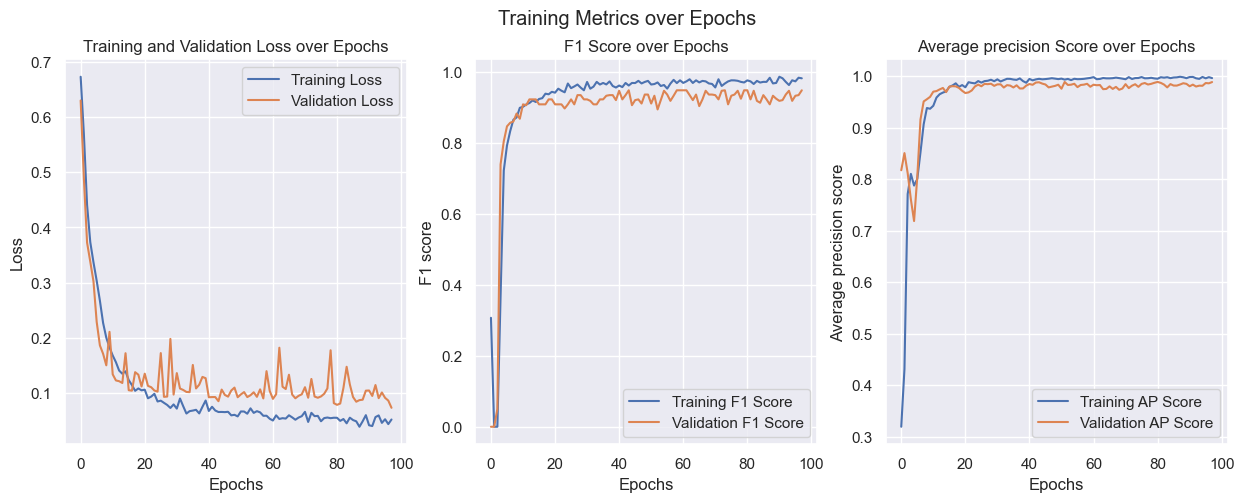

Saving...
Complete the process...


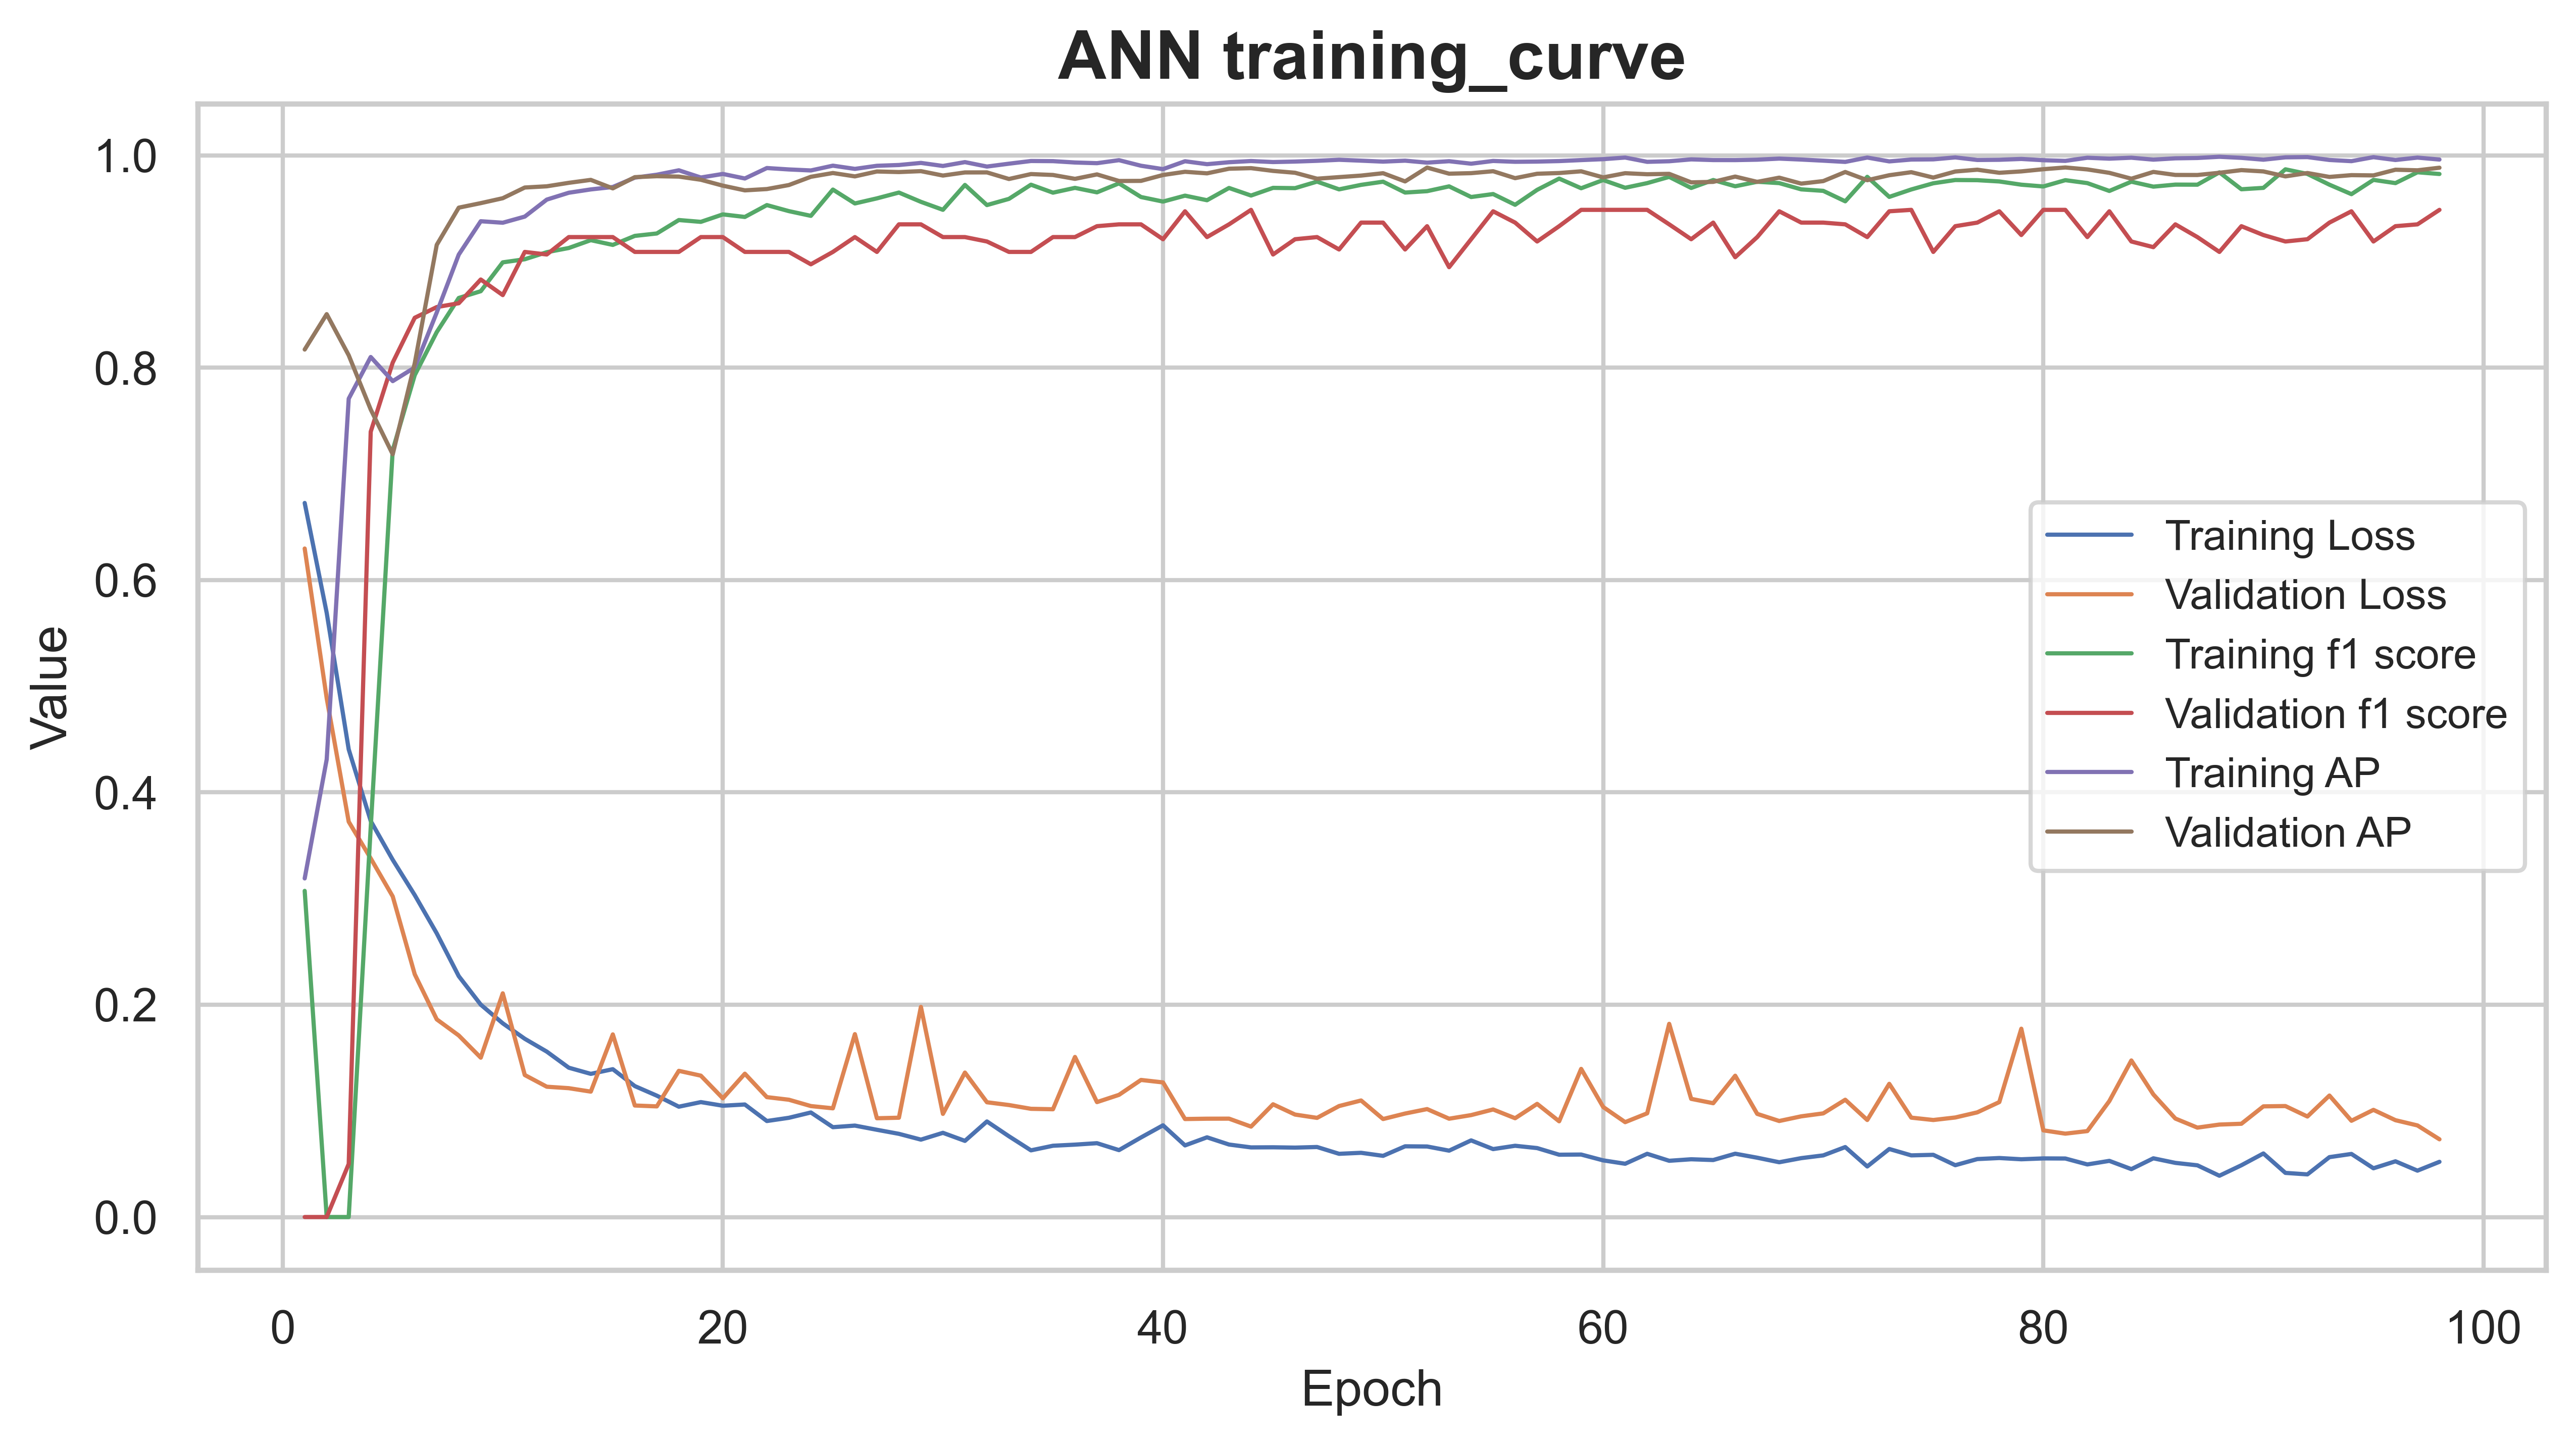

In [33]:
ann_training_curve(study.best_trial)

### **2.2.5. Compare baseline and optimize model**

Baseline vs. Tune: Custom statistical test, P_val:1.863e-09


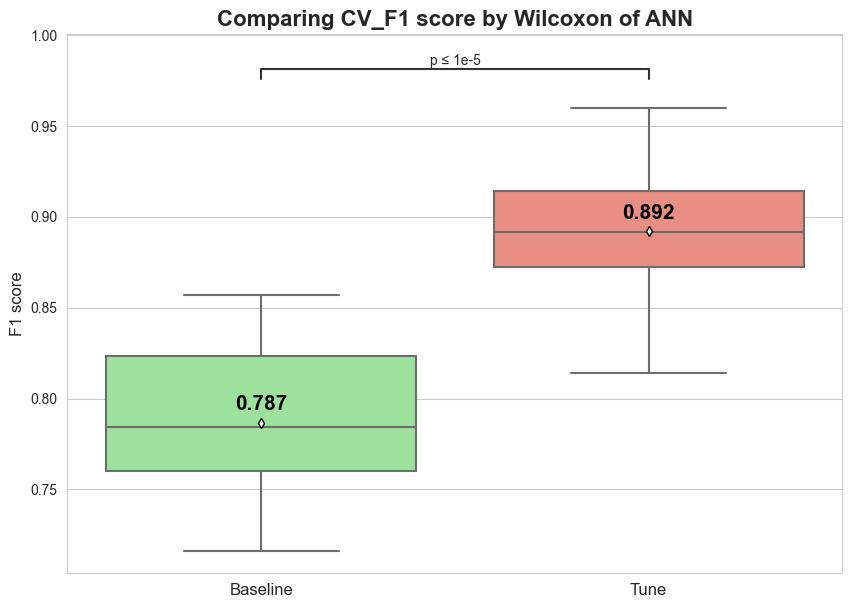

Baseline vs. Tune: Custom statistical test, P_val:3.725e-09


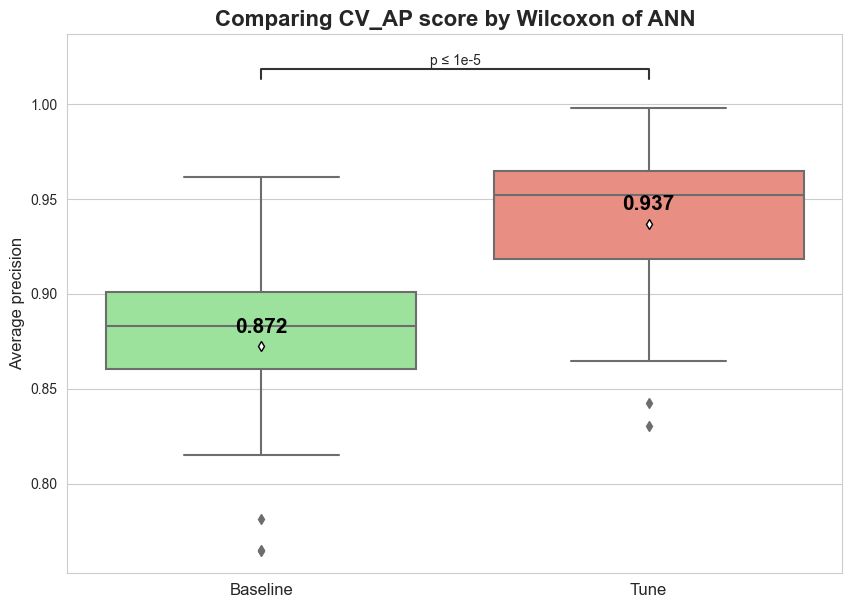

In [18]:
from ANN_utility.Utils import compare_opt_boxplot

df_baseline = pd.read_csv("./Database/ANN_cv_baseline.csv")
df_tune = pd.read_csv("./Database/ANN_cv_best.csv")

#f1 score comparing
baseline_f1 = df_baseline["F1_record"]
tune_f1 = df_tune["F1_record"]
path_f1 = "./Database/ANN_f1_compare_tune.png"
compare_opt_boxplot(baseline_f1, tune_f1, metric = "F1 score", fig_name="Comparing CV_F1 score by Wilcoxon of ANN", save_path = path_f1)

#average precision comparing 
baseline_ap = df_baseline["AP_record"]
tune_ap = df_tune["AP_record"]
path_ap = "./Database/ANN_ap_compare_tune.png"
compare_opt_boxplot(baseline_ap, tune_ap, metric = "Average precision", fig_name="Comparing CV_AP score by Wilcoxon of ANN", save_path = path_ap)